[View in Colaboratory](https://colab.research.google.com/github/sagar-m/character-classification/blob/master/character_classification2.ipynb)

In [1]:
# this is for google drive, please ignore

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
# this is for google drive, please ignore
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
#just checking the data size
#import pandas as pd
#xtrain = pd.read_csv('drive/coursera/xtrain_obfuscated.csv')
#xtrain.shape

In [0]:

##just checking the data size

#import pandas as pd
#ytrain = pd.read_csv('drive/coursera/ytrain.csv')
#print(ytrain.shape)
#print(ytrain.tail(5))

In [0]:
import os
import time
import numpy as np
import pandas as pd


In [0]:
#just checking the data size
#xtest = pd.read_csv('drive/coursera/xtest_obfuscated.csv')
#xtest.shape

In [7]:

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

from pickle import dump
from keras.utils import to_categorical, np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np

Using TensorFlow backend.


In [0]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [9]:
#@title
## preprocessing 1


data = open('drive/coursera/xtrain_obfuscated.txt','r').read()
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('There are %d total characters and %d unique characters in data.' % (data_size,vocab_size))
print(len(chars))
chars[1]



There are 13473041 total characters and 27 unique characters in data.
27


'w'

In [10]:
## preprocessing 2

#@title
#hash table

char_to_ix = { ch:i for i,ch in enumerate(sorted(chars)) }
ix_to_char = { i:ch for i,ch in enumerate(sorted(chars)) }
print("char_to_ix = ", "\n", ix_to_char,"\n"*2) 
print("ix_to_char = ", "\n", char_to_ix)

char_to_ix =  
 {0: '\n', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'} 


ix_to_char =  
 {'\n': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


In [11]:
## preprocessing 3


#@title
#print(xtrain.head(1))
#print(examples.head(1).map(str).apply(len))
#print(list(map(len, X[[10]]))) 
#print(list(map(len, xtrain.iloc[[10]]))) 

examples = data.split('\n')
#print(examples[1:3],"\n")
#print(len(examples),"\n")

X = []
Y = []
for index in range(len(examples)):
    lineX = [char_to_ix[ch] for ch in examples[index]]
    X.append(lineX)
    lineY = lineX[1:] + [char_to_ix["\n"]]
    Y.append(lineY)
print("X[32513]:", X[32153])
#print("Y[1]:", Y[1], "\n") 
print(len(X),len(Y))


X[32513]: [21, 12, 24, 5, 20, 23, 9, 23, 21, 8, 20, 23, 4, 6, 21, 8, 10, 26, 17, 22, 22, 9, 12, 5, 20, 23, 21, 12, 22, 9, 5, 14, 9, 23, 21, 8, 1, 13, 21, 12, 13, 22, 4, 6, 21, 8, 17, 7, 21, 12, 17, 22, 5, 14, 20, 23, 12, 5, 20, 22, 5, 14, 21, 8, 12, 18, 22, 9, 13, 22, 7, 26, 20, 23, 20, 23, 21, 3, 21, 8, 9, 23, 9, 23, 5, 14, 21, 8, 17, 7, 1, 13, 25, 16, 12, 5, 5, 14, 20, 23, 17, 22, 21, 8, 1, 13, 12, 18, 11, 18, 16, 13, 12, 5, 16, 13, 1, 13, 21, 12, 21, 8, 22, 9, 5, 14, 12, 18, 20, 23, 20, 22, 21, 8, 21, 12, 17, 22, 20, 23, 12, 5, 21, 8, 20, 23, 1, 13, 21, 12, 21, 8, 20, 23, 9, 23, 13, 22, 1, 13, 4, 6, 21, 8, 17, 7, 5, 26, 9, 23, 20, 23, 1, 13, 21, 8, 20, 23, 1, 13, 21, 12, 21, 8, 20, 23, 21, 3, 5, 14, 21, 12, 21, 8, 5, 26, 13, 22, 1, 13, 21, 8, 21, 12, 20, 23, 9, 23, 21, 8, 9, 7, 21, 8, 18, 1, 20, 23, 21, 3, 13, 22, 7, 26, 17, 22, 19, 11, 22, 9, 5, 14, 1, 13, 21, 8, 5, 14, 21, 8, 1, 13, 21, 12, 13, 22, 4, 6, 21, 8, 20, 23, 9, 23, 20, 22, 11, 18, 16, 13, 12, 5, 21, 12, 21, 8, 24, 5, 16

In [12]:
# preparing xtrain part 1...............######


from pickle import dump
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
 
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text
 
# load
in_filename = 'drive/coursera/xtrain_obfuscated.txt'
raw_text = load_doc(in_filename)
lines = raw_text.split('\n')
 
# integer encode sequences of characters
chars = sorted(list(set(raw_text)))
mapping = dict((c, i) for i, c in enumerate(chars))
sequences = list()
for line in lines:
	# integer encode line
	encoded_seq = [mapping[char] for char in line]
	# store
	sequences.append(encoded_seq)
 
# vocabulary size
vocab_size = len(mapping)
print('Vocabulary Size: %d' % vocab_size)
 
# separate into input and output
sequences = np.array(sequences)
X = sequences
sequences = [to_categorical(x, num_classes=vocab_size) for x in X]
#X = np.array(sequences)
print(X[32513:32514])
print(len(X))


Xtrain = X[:-1]
print(len(Xtrain))
#print(Xtrain[0:1])

#y = to_categorical(y, num_classes=vocab_size)

Vocabulary Size: 27
[list([])]
32514
32513


In [0]:


#(batch_size, input_dim)
#(batch_size, timesteps, input_dim)




In [13]:
# preparing xtrain part 2...............######


longest_sentence = len(max(Xtrain, key=len))+1
print(longest_sentence)
shortest_sentence = len(min(Xtrain, key=len))+1
print(shortest_sentence)

453
169


In [14]:
# preparing xtrain part 3...............######

#padding all vectors to length 453

sample = len(Xtrain)
print(sample)
vocab_size = len(char_to_ix)

from keras.preprocessing import sequence
Xtrain = sequence.pad_sequences(Xtrain, maxlen=longest_sentence,padding="post")

print("Xtrain[1]:", Xtrain[1], "\n") 

32513
Xtrain[1]: [20 23 13 11  9 23 16 13 17 22 20 23 12  5 21  8 19  1  9 23 19 11 20 23
 13 22 12  5 12  5 11 18  1 13 21  8 17 22 11 18 21  8 20 23 19 11  5 14
  5 26 21  8 19 11 22  9  5 14 21  8 17  7 21 12 22  9  5 14 21 12 17 22
 22  9 13 22 21  8 22  9  5 14 21  8 22  9 13 22 21  8 21 12 25 16 20 23
  2 18 20 22 11 18 17 22 21  8 20 23  1 13 21 12 21  8 19 11 20 23 12 18
 22  9  5 14  1 13 25 16 21  8 17 22 13 22  1 13  7 21 21  8 22  7 15  1
 21 12  1 13 12 18 13 22 22  9  2  8 16 13 21 12 21  8 17 22  9 10 21 12
 13 22 14 11 21  8 17  7 19 11 11 18 16 13  9 23  5 14 21  8 19 11 20 23
 19 11 19 11  5 14 21  8 19  1  9 23 13 22 12  5  5 14 21 12 22  9 11 18
  9 23 16 13 13 11 22  9 13 22 21  8  9  7 21  8 22  7 17  7 21 12 12  5
  5 14 20 23  1 13 21  8 19  1  5 26 21  8 17 22 17 22 20 23  9 23 20 22
 21  8 19 11 22  9 19 11 14 11 21  8 18  1 22  9  4  6 16 13 22  9 20 23
 12  5 21  8 22  9  5 14 13 22 25 16 17 22 16 13 10  5 21  8 24  5 16 13
 21  8 12  5 11 18 20 23 21 12  5 

In [15]:
# preparing xtrain part 4...............######


#create one-hot vector

print(sample,longest_sentence,vocab_size)


X_onehot = np.zeros((sample,longest_sentence,vocab_size))

for i, indices in enumerate(Xtrain):
  for j, character_index in enumerate(indices):
    X_onehot[i,j,character_index] = 1

#print(X_onehot.info())

32513 453 27


In [16]:
# preparing y part 1...............######


y = open('drive/coursera/ytrain.txt','r').read()
#chars = list(set(data))
y = y.split()
print(len(y))
print(y[32470:32513])
#print(y.info())

#print(np.percentile(y,[0, 100]))


#y = y.values
#ytrain = y.ravel()
y = to_categorical(y, num_classes=12)
#print(y.info())
print(y[32512:32513])




32513
['3', '6', '6', '10', '3', '6', '10', '7', '8', '7', '10', '10', '1', '7', '4', '8', '7', '3', '6', '6', '11', '6', '8', '5', '7', '11', '3', '7', '11', '8', '7', '6', '1', '1', '1', '10', '0', '7', '6', '10', '10', '6', '3']
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [17]:
# preparing xtest part 1...............######

# load
in_filename = 'drive/coursera/xtest_obfuscated.txt'
raw_text = load_doc(in_filename)
lines = raw_text.split('\n')
 
# integer encode sequences of characters
chars = sorted(list(set(raw_text)))
mapping = dict((c, i) for i, c in enumerate(chars))
sequences1 = list()
for line in lines:
	# integer encode line
	encoded_seq = [mapping[char] for char in line]
	# store
	sequences1.append(encoded_seq)
 
# vocabulary size
vocab_size = len(mapping)
print('Vocabulary Size: %d' % vocab_size)
 
# separate into input and output
sequences1 = np.array(sequences1)
Xtests = sequences1
sequences1 = [to_categorical(x, num_classes=vocab_size) for x in Xtests]
#X = np.array(sequences)

print(len(sequences1))

print(sequences1[2999:3000])
print(len(Xtests))

print(Xtests[3000:3001])

Xtest = Xtests[:-1]
print(len(Xtest))


Vocabulary Size: 27
3001
[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)]
3001
[list([])]
3000


In [18]:
## preparing test set part 2

longest_sent = len(max(Xtest, key=len))+1
print(longest_sent)
shortest_sent = len(min(Xtest, key=len))+1
print(shortest_sent)

449
73


In [19]:
## preparing test set part 3


#padding all vectors to length 453

sample1 = len(Xtest)
print(sample1)
#vocab_size = len(char_to_ix)

from keras.preprocessing import sequence
Xtest = sequence.pad_sequences(Xtest, maxlen=longest_sentence,padding="post")

print("Xtest[1]:", Xtest[1], "\n") 

3000
Xtest[1]: [17 22 13 22 21  8 19 11 12  5  5 14 13 22 22  9  5 14  7 26 24 25 21  8
 17 22 13 22  1 13  7 21 21  8 18  1 11 18 16 13 19  1 21  8 21 12 25 16
 20 23 21 12 16 13 12  5  7 26 21  8 19 11  9  7  2  8  2  8 11 18 16 13
 19  1 21  8 21 12 25 16 20 23 21 12 16 13 12  5  7 26 21  8 19 11  9  7
  2  8  2  8 16 13  6 17 21  8 18  1 19 11  9 23 12  5 16 13  4  6 21  8
 20 23  1 13 21 12 21  8  9 23  9 23  5 14 21  8 12  5 16 13 24  5 21  8
 19 11  5 14 20 23  1 13 21  8 12  5 11 18 16 13 19  1 21  8 24  5 16 13
 21  8 12  5 13 22  5 14  1 13 21  8  5 14 21  8 21 12 12  5 11 18  1 13
 21  8 21 12 22  9 19 11  9 23 11 18 16 13  4  6 21  8  9  7 21  8 18  1
 20 23  5 26 21  8 24  5 16 13 21  8 19 11 13 22  5 14 12  5 24  5  5 14
 21  8 20 23 20 22 21  8 21 12 22  9 16 13 19 11 21  8 17  7 19  1 16 13
 20 22 21  8 19  1 17 10 21  8 18  1 12  5 20 23 19 11 22  9 11 18  9 23
 20 22 21  8 12  5 20 23 21 12 24  5  5 14 21  8 12  5 20 23 19 11 22  9
 11 18  9 23 20 22 21  8 20 23 19 11

In [20]:
## preparing test set part 4

#create one-hot vector

print(sample1,longest_sentence,vocab_size)


Xtest_onehot = np.zeros((sample1,longest_sentence,vocab_size))

for i, indices in enumerate(Xtest):
  for j, character_index in enumerate(indices):
    Xtest_onehot[i,j,character_index] = 1

print(Xtest_onehot[0:1])

3000 453 27
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]]


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 453, 32)           7680      
_________________________________________________________________
lstm_2 (LSTM)                (None, 453, 32)           8320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 12)                396       
Total params: 24,716
Trainable params: 24,716
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
 - 750s - loss: 2.3313 - acc: 0.1620
Epoch 2/15
 - 753s - loss: 2.3018 - acc: 0.1736
Epoch 3/15
 - 753s - loss: 2.2854 - acc: 0.1906
Epoch 4/15
 - 761s - loss: 2.2634 - acc: 0.1942
Epoch 5/15
 - 750s - loss: 2.2496 - acc: 0.1928
Epoch 6/15
 - 750s - loss

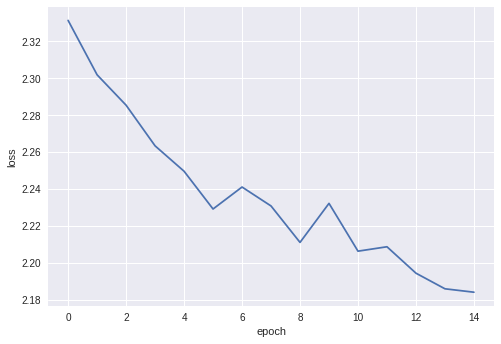

In [21]:
## Run model here


### RNN blog https://machinelearningmastery.com/develop-character-based-neural-language-model-keras/#comment-439443

num_classes = 12

#
 
# define model

model = Sequential()
model.add(LSTM(32, return_sequences=True,
               input_shape=(longest_sentence,vocab_size)))  # returns a sequence of vectors of dimension 32
model.add(LSTM(32, return_sequences=True))  # returns a sequence of vectors of dimension 32
model.add(LSTM(32))  # return a single vector of dimension 32
model.add(Dense(12, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())
# fit model

#history = model.fit(X_onehot, y, batch_size=128, epochs=30, verbose=2, validation_split=0.20)

history = model.fit(X_onehot, y, batch_size=128, epochs=15, verbose=2)


#from matplotlib import pyplot
#pyplot.plot(history.history['loss'])
#pyplot.plot(history.history['val_loss'])
#pyplot.title('model train vs validation loss')
#pyplot.ylabel('loss')
#pyplot.xlabel('epoch')
#pyplot.legend(['train', 'validation'], loc='upper right')
#pyplot.show()

from matplotlib import pyplot
pyplot.plot(history.history['loss'])
#pyplot.plot(history.history['val_loss'])
#pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
#pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

# save the model to file
model.save('model.h5')
# save the mapping
dump(mapping, open('mapping.pkl', 'wb'))



In [0]:
# test model here

#model = load_model('model.h5')
# make predictions
yhat1 = model.predict_classes(Xtest_onehot)
yhat2 = np.argmax(model.predict(Xtest_onehot))

#print(yhat.head())

#score = model.evaluate(Xtest_onehot, y_test, batch_size=128)

In [27]:
print(len(str(yhat2)))

print(len(yhat1))
print(yhat1[1:10])


print(np.max(yhat1, axis=0) - np.min(yhat1, axis=0))
print(np.max(yhat1, axis=0))
print(np.min(yhat1, axis=0))




4
3000
[7 7 7 4 7 7 7 6 8]
10
10
0


In [29]:
print(yhat2)

4892
